In [ ]:
!pip install biopython

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 26.7 MB/s eta 0:00:00


In [ ]:
!pip install mhcflurry
!mhcflurry-downloads fetch


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.9/140.9 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.7/103.7 kB 9.0 MB/s eta 0:00:00
  Created wheel for typechecks: filename=typechecks-0.1.0-py3-none-any.whl size=2752 sha256=f56f8a4a0f176f6065570d779b499e911e1ff04629e720fec49d1dcd95d6d549
  Stored in directory: /root/.cache/pip/wheels/b4/fb/17/c339a76041556c9cf0ab9a76acaaaf119ec8019357d6d601b7
Successfully built typechecks
Fetching 3/22 downloads from release 2.2.0
DOWNLOAD NAME                             ALREADY DOWNLOADED?    WILL DOWNLOAD NOW?    URL                  
models_class1_pan                         NO                     NO                    https://github.com/openvax/mhcflurry/releases/download/pre-2.0/models_class1_pan.selected.20200610.tar.bz2 
models_class1_presentation                NO                     YES                   https://github.com/openvax/mhcflurry/releases/download/pre-2.0/models_c

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


Protein length: 566
M: 1.24%
K: 7.24%
A: 6.01%
I: 6.54%
L: 7.95%
V: 6.54%
Y: 4.77%
T: 6.54%
F: 3.36%
N: 7.24%
D: 4.59%
C: 2.65%
G: 6.89%
H: 2.65%
S: 8.30%
E: 6.54%
R: 3.18%
P: 3.36%
W: 1.77%
Q: 2.65%
1/1 [==============================] - 0s 27ms/step

Top predicted epitopes per allele:
        Peptide       Allele  Predicted_IC50
802   KMNTQFTAV  HLA-A*02:01       17.628091
862   FLDIWTYNA  HLA-A*02:01       22.386309
774   AIDEITNKV  HLA-A*02:01       32.892549
658   RLATGLRNV  HLA-A*02:01       36.180601
1070  TVASSLVLV  HLA-A*02:01       36.256783
484   RMNYYWTLV  HLA-A*02:01       38.470278
1090  SLGAISFWM  HLA-A*02:01       40.430395
68    TVLEKNVTV  HLA-A*02:01       42.059957
613   LPFQNIHPI  HLA-B*07:02       49.531877
305   CPHAGAKSF  HLA-B*07:02       50.103919
675   VPSIQSRGL  HLA-B*07:02       50.785983
349   YPKLSKSYI  HLA-B*07:02       51.463235
362   YINDKGKEV  HLA-A*02:01       70.334841
12    VLLYTFATA  HLA-A*02:01       71.159575
595   TPKGAINTS  HLA-B*07:02      122

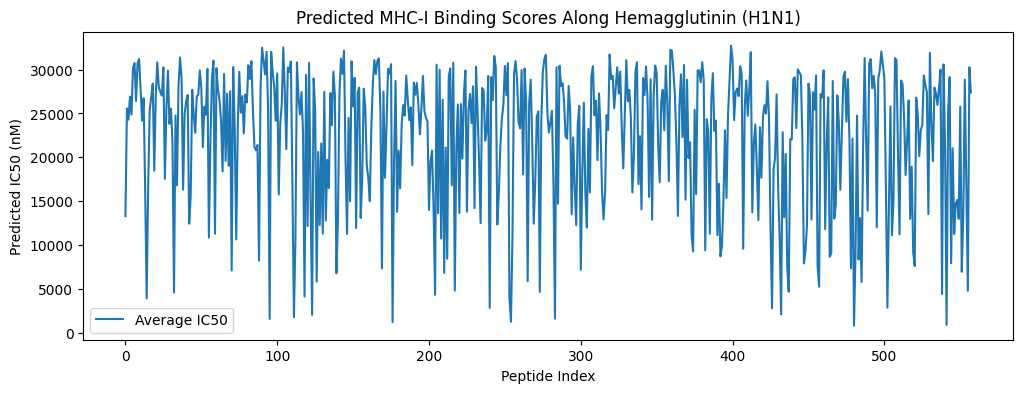

In [ ]:

from Bio import Entrez, SeqIO
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
from mhcflurry import Class1AffinityPredictor

Entrez.email = "your_email@example.com"
handle = Entrez.efetch(db="protein", id="BDC79445.1", rettype="fasta", retmode="text")
record = SeqIO.read(handle, "fasta")
handle.close()

protein_seq = str(record.seq)
print(f"Protein length: {len(protein_seq)}")


aa_count = Counter(protein_seq)
total = len(protein_seq)

composition = {aa: count/total for aa, count in aa_count.items()}
for aa, perc in composition.items():
    print(f"{aa}: {perc:.2%}")


def get_peptides(seq, length=9):
    return [seq[i:i+length] for i in range(len(seq)-length+1)]

peptides = get_peptides(protein_seq)


predictor = Class1AffinityPredictor.load()
alleles = ["HLA-A*02:01", "HLA-B*07:02"]
results = []

for peptide in peptides:
    for allele in alleles:

        score_array = predictor.predict([peptide], [allele])
        score = score_array[0]
        results.append({
            "Peptide": peptide,
            "Allele": allele,
            "Predicted_IC50": score
        })

df = pd.DataFrame(results)


top_epitopes = df.sort_values(by="Predicted_IC50").groupby("Allele").head(10)
print("\nTop predicted epitopes per allele:")
print(top_epitopes)


df.to_csv("all_peptides_HA_real.csv", index=False)
top_epitopes.to_csv("top_epitopes_HA_real.csv", index=False)

mean_scores = df.groupby("Peptide")["Predicted_IC50"].mean().values

plt.figure(figsize=(12,4))
plt.plot(range(len(peptides)), mean_scores, label='Average IC50')
plt.xlabel("Peptide Index")
plt.ylabel("Predicted IC50 (nM)")
plt.title("Predicted MHC-I Binding Scores Along Hemagglutinin (H1N1)")
plt.legend()
plt.show()

